In [112]:
import os
from shutil import copyfile, rmtree

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow


import warnings; warnings.simplefilter('ignore')

import PIL
from PIL import ImageDraw

from tqdm import tqdm_notebook

%matplotlib inline


In [57]:
data_dir = "./coordinates/"

In [58]:
torch.cuda.current_device()

0

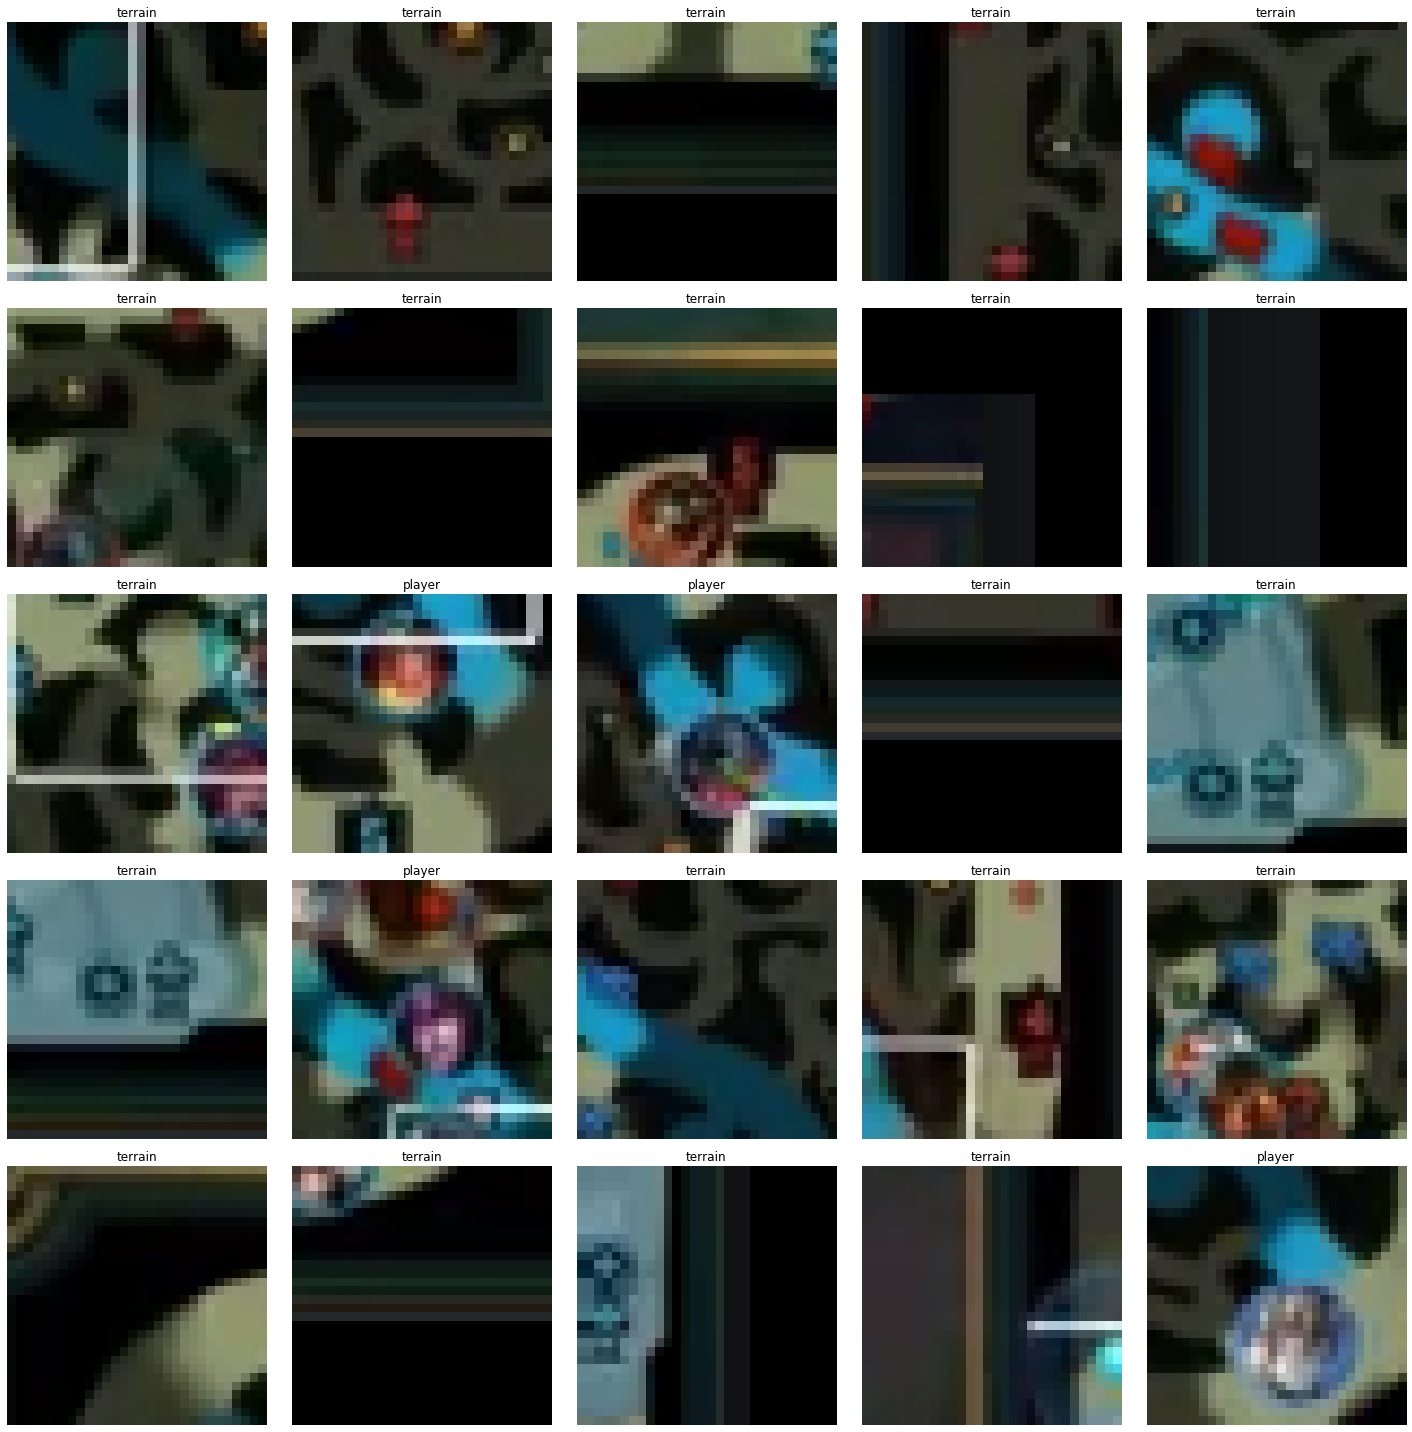

In [59]:
tfms = [[crop_pad()], [crop_pad()]]
data = ImageDataBunch.from_folder(data_dir+"split", classes=["terrain", "player"], bs=256, ds_tfms=tfms)
data.show_batch()

In [60]:
def get_score(learn):
    preds = learn.get_preds(DatasetType.Valid)[0]
    score = 0
    for i in range(len(learn.data.valid_dl.y)):
        if preds[i][0] > preds[i][1] and learn.data.valid_dl.y[i].data == 0:
            score+=1
        elif preds[i][0] < preds[i][1] and learn.data.valid_dl.y[i].data == 1:
            score+=1    

    return score

In [61]:
best_learn = None
best_score = 0
lr = 0.02

for i in range(0, 1):
    learn = create_cnn(data, models.resnet101, metrics=[accuracy])
    gc.collect()
    learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]
    learn.fit_one_cycle(1, lr)
    learn.unfreeze()
    learn.fit_one_cycle(3, slice(1e-6, lr/5))

    new_score = get_score(learn)
    if new_score > best_score or not best_learn:
        best_learn = learn
        best_score = new_score
    print(f'Run {i} - Best Score: {best_score}')

epoch,train_loss,valid_loss,accuracy,time
0,0.072578,0.062735,0.974955,00:44


Better model found at epoch 0 with valid_loss value: 0.06273545324802399.


epoch,train_loss,valid_loss,accuracy,time
0,0.063757,0.059254,0.975479,00:56
1,0.045967,0.052884,0.979147,00:56
2,0.022948,0.060944,0.979199,00:56


Better model found at epoch 0 with valid_loss value: 0.059253763407468796.
Better model found at epoch 1 with valid_loss value: 0.05288415029644966.


Run 0 - Best Score: 18688


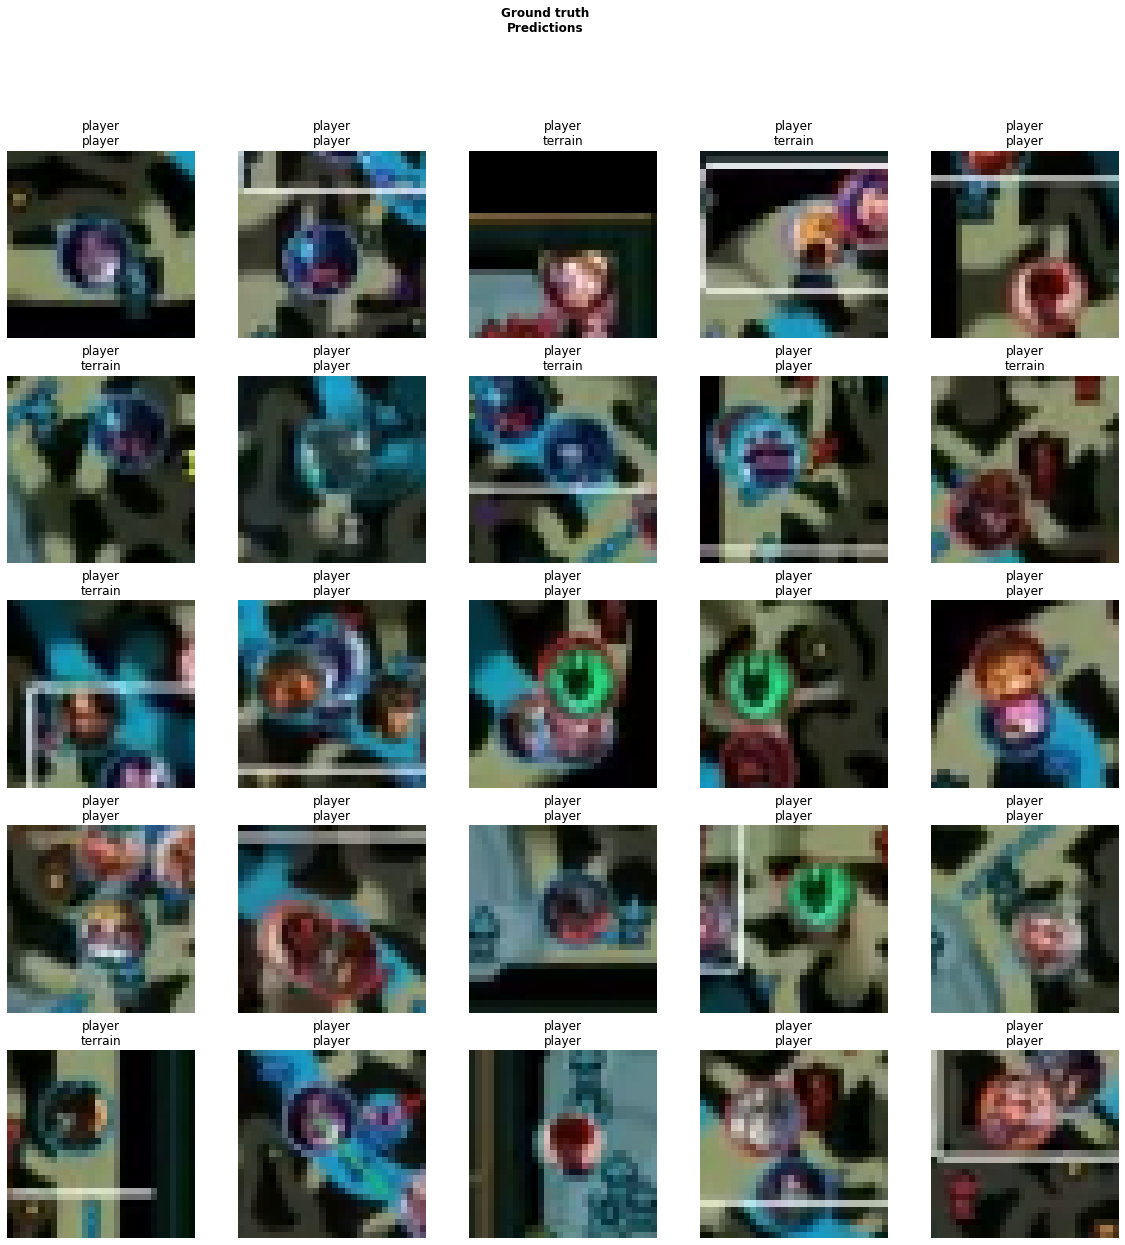

In [62]:
best_learn.show_results()

### Test on Images

In [113]:
grid_size = 10
prediction_threshold = 0.20

def empty_dir(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)
            
def draw_grid(draw, labels):
    fill = (0, 255, 255, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)
        
def draw_preds(filename, grids): 
    img = PIL.Image.open(filename)

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, grids)
    out = PIL.Image.alpha_composite(img, overlay)

    imshow(np.asarray(out))
    
def get_predictions(learner, predictions):
    # Predict the grid image types
    tmp_dir = data_dir + "tmp"
    test = ImageList.from_folder(tmp_dir)
    learner.data.add_test(test)
    preds = learner.get_preds(ds_type=DatasetType.Test)
    num_preds = len(preds)
    z = 0

    # Identify the grids which are player squares
    player_grids = []
    for i in range(len(preds[1])):
        if preds[0][i][1] > prediction_threshold:
            img = test.items[i]
            fname = img.stem
            num = int(fname.split("-")[1])
            name = fname.split("-")[0]
            x = num//1000
            y = num%1000
            predictions[name].append((x,y))
            
    
    empty_dir(tmp_dir)
    return predictions
    

def get_grids(learner, filenames):
    print("locating player positions...")
    padding = 10
    num_files = len(filenames)
    predictions = {}
    # Split the image into grids and save the components to the tmp directory.
    tmp_dir = data_dir+"tmp"
    empty_dir(tmp_dir)
    z = 0
    numfiles = len(filenames)
    for l in tqdm_notebook(range(numfiles)):
        f = filenames[l]
        im = PIL.Image.open(f)
        imgwidth, imgheight = im.size
        base=os.path.basename(f)
        fname = os.path.splitext(base)[0]
        predictions[fname] = []
        for i in range(0, imgheight, grid_size):
            for j in range(0, imgwidth, grid_size):
                box = (j-padding, i-padding, j + grid_size + padding, i + grid_size + padding)
                a = im.crop(box)
                a.save(data_dir+f"tmp/{fname}-{j*1000//grid_size+i//10}.png")
                
        if z% 1000 == 0:
            predictions = get_predictions(learner, predictions)
        z += 1
    
    if len(os.listdir(tmp_dir)) > 0:
        predictions = get_predictions(learner, predictions)

    return predictions

In [114]:
i = 600

['games/hka_lk_worlds_2019/full/hka_lk_worlds_2019_0000000600.png']
locating player positions...


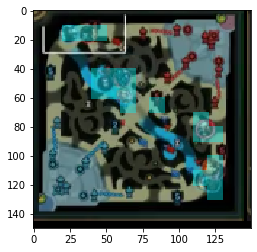

In [115]:
s = str(i)
s = "0"*(3-len(s)) + s
filenames = [f"games/hka_lk_worlds_2019/full/hka_lk_worlds_2019_0000000{s}.png"]
print(filenames)
grids = get_grids(best_learn, filenames)
base = os.path.basename(filenames[0])
fname = os.path.splitext(base)[0]
draw_preds(filenames[0], grids[fname])
i += 1

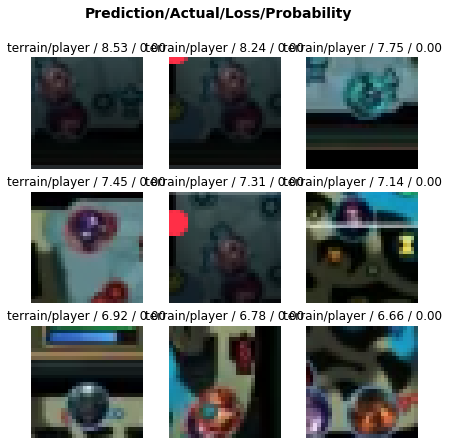

In [124]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(best_learn, preds, y, losses)
interp.plot_top_losses(9, figsize=(7,7))

In [74]:
model_path = 'models/'
learn.export(model_path+"coordinator.pth")

### Collect Games Maps

Gather all the maps from each game into a single "full" folder and "team" folder. These two folders will be the source for training the final map prediction model.

In [75]:
collected_dir = "games_collected/"
games_dir = "games/"
empty_dir(collected_dir + "full")
empty_dir(collected_dir + "team")

games = os.listdir(games_dir)
for g in games:
    if g == ".DS_Store":
        os.remove(games_dir+g)
        continue
    full_dir = games_dir + g + "/full/"
    full_images = os.listdir(full_dir)
    for img in full_images:
        if ".jpg" in img or ".png" in img:
            copyfile(full_dir + img, collected_dir + "full/" + img)
    
    team_dir = games_dir + g + "/team/"
    team_images = os.listdir(team_dir)
    for img in team_images:
        if ".jpg" in img or ".png" in img:
            copyfile(team_dir + img, collected_dir + "team/" + img)

print(f"Full images: {len(os.listdir(collected_dir + 'full'))}")
print(f"Team images: {len(os.listdir(collected_dir + 'team'))}")

Full images: 38389
Team images: 38389


In [30]:
# fulls = os.listdir(data_dir + 'full')
# teams = os.listdir(data_dir + 'team')
# for f in fulls:
#     if f not in teams:
#         print(f)
# shutil.rmtree(data_dir + 'full/models')

### Create Full Map Coordinates

Use the model we trained to predict the coordinates of each player in the maps. This csv will be used as the target in the final map prediction model.

In [116]:
tmp_dir = data_dir + "tmp"
empty_dir(tmp_dir)

In [118]:
fnames = []
tags = []
files = os.listdir(collected_dir + "full")

files = [f"{collected_dir}/full/{f}" for f in files]
grids = get_grids(best_learn, files)

for k,v in grids.items(): 
    v = [f"{g[0]}-{g[1]}" for g in v]
    v.sort()
    v = " ".join(v)
    fnames.append(k)
    tags.append(v)
    
df = pd.DataFrame({'image_name':fnames, 'tags':tags}, columns=['image_name', 'tags'])

locating player positions...


Some screenshots aren't valid mini-maps. Sometimes animations from the league feed block the map. Remove these invalid targets from the csv.

In [119]:
convert_dict = {'image_name': str, 'tags': str} 
  
df = df.astype(convert_dict)
df.replace('', np.nan, inplace=True)
df.dropna(subset=['tags'], inplace=True)
df.to_csv(collected_dir+"full_coordinates.csv", index=False)